# Introduction

This notebook demonstrates the use of PanCAKE with the MIRI coronagraphs, and contrasts PanCAKE with default Pandeia coronagraphy calculations. In particular, it provides examples of:

* Constructing a MIRI scene in both Pandeia and PanCAKE
* Importing a MIRI scene built in Pandeia into PakCAKE
* Engine calculations using Pandeia's precomputed PSF library, in both Pandeia and PanCAKE
* Comparisons of Pandeia's precomputed PSF library with PanCAKE's on-the-fly PSF generation
* Comparisons of on-the-fly PSF generation with varying numbers of wavelength bins

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from stsci_pancake import scene, analysis, transformations, engine

from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.perform_calculation import perform_calculation

from copy import deepcopy
import numpy as np
import time

# Constructing a Scene

We'll start by defining the source and instrument properties for our desired observation. 

In [13]:
target_mV = 4.7
ref_mV = 3.

target_Sp = 'a5v'
ref_Sp = 'a3v'

subarray = 'mask1065'
filter_c = 'f1065c'
mask_c = 'fqpm1065'

ngroup = 10
nint = 1

Now we'll create in a MIRI template from Pandeia and configure the instrument for our observation. (In this case, it's already configured for a F1065C observation, but we'll demonstrate setting the calculation keys regardless.)

In [14]:
# Load the template
config = build_default_calc('jwst', 'miri', 'coronagraphy')

# Set the coronagraph and filter
config['configuration']['detector']['subarray'] = subarray
config['configuration']['detector']['ngroup'] = ngroup
config['configuration']['instrument']['aperture'] = mask_c
config['configuration']['instrument']['filter'] = filter_c

This template contains a scene with a single star. We'll set the star properties and then duplicate it to create a planetary companion.

In [15]:
# Pull out the target (the first entry in the 'scene' list)
targetstar = config['scene'][0]
targetstar['spectrum']['normalization']['norm_flux'] = target_mV
targetstar['spectrum']['sed']['key'] = target_Sp
targetstar['id'] = 1

# Copy the target star and turn it into a planet
planetA = deepcopy(targetstar)
planetA['id'] = 2 #each source must have a unique ID, starting at 1

# A different way to normalize source flux
planetA['spectrum']['normalization']['bandpass'] = 'miri,imaging,f1500w'
planetA['spectrum']['normalization']['norm_flux'] = 15.3
planetA['spectrum']['normalization']['type'] = 'jwst'
planetA['spectrum']['sed']['sed_type'] = 'blackbody'
planetA['spectrum']['sed']['temp'] = 900.
del planetA['spectrum']['sed']['key'] #unnecessary now

# Source offset
planetA['position']['x_offset'] = 2.3 #arcsec
planetA['position']['y_offset'] = 3.1

# Update calculation file with the new planet
config['scene'].append(planetA)

Create the reference scene for PSF subtraction:

In [16]:
# We adopt a brighter but spectrally-mismatched reference
config['strategy']['psf_subtraction_source']['spectrum']['normalization']['norm_flux'] = ref_mV
config['strategy']['psf_subtraction_source']['spectrum']['sed']['key'] = ref_Sp
config['strategy']['psf_subtraction_source']['id'] = 3

And now we'll plot the two scenes we've constructed

(0, 5.0)

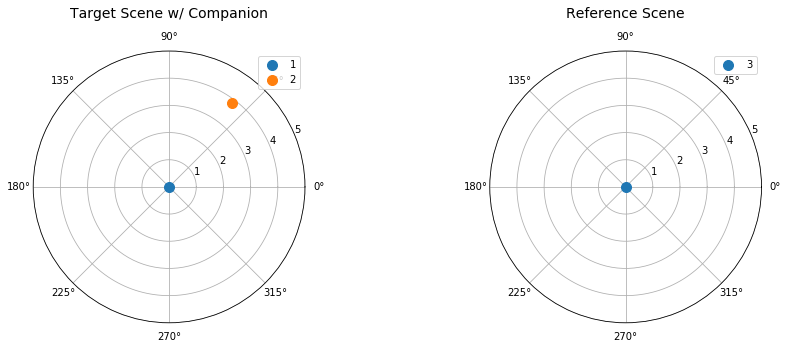

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(121,polar=True)
scene.plot_scene(config['scene'],'Target Scene w/ Companion',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)
plt.subplot(122,polar=True)
scene.plot_scene([config['strategy']['psf_subtraction_source']],'Reference Scene',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)

# Run the Pandeia Engine

Now we pass our calculation files to the pandeia engine to create the slope images (and a number of other products).

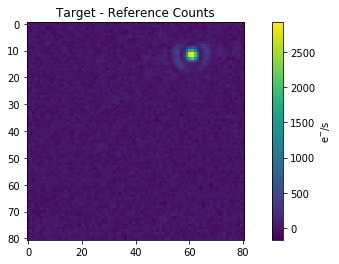

In [7]:
pandeia_result = perform_calculation(deepcopy(config))

subtracted_slope = pandeia_result['2d']['detector']

plt.figure(figsize=(10,4))
plt.imshow(subtracted_slope)
plt.title('Target - Reference Counts')
plt.colorbar().set_label('e$^{-}$/s')

In order to run the same calculation via panCAKE, the convenience function ``engine.calculate_subtracted`` will generate similar results to Pandeia's optimally-subtracted calculation:

In [ ]:
pancake_result = engine.calculate_subtracted(config)

subtracted_slope = pancake_result['subtracted']

plt.figure(figsize=(10,4))
plt.imshow(subtracted_slope)
plt.title('Target - Reference Counts')
plt.colorbar().set_label('e$^{-}$/s')

To demonstrate the difference between the two data reductions, the following plot shows the result of subtracting the panCAKE image from the pandeia image.

In [ ]:
difference_image = pandeia_result['2d']['detector'] - pancake_result['subtracted']

plt.figure(figsize=(10,4))
plt.imshow(difference_image)
plt.title('Pandeia - PanCAKE')
plt.colorbar().set_label('e$^{-}$/s')

### Wave Sampling

An aside on performance and accuracy: The ```engine.options.wave_sampling``` parameter provides a hook into the wavelength sampling of the 3D (x,y,wavelength) cube. By default, Pandeia adopts some large value for the wavelength sampling (typically 150+); however, this is the primary time sink in the calculation. Setting ```engine.options.wave_sampling = 11``` while developing your simulation provides dramatic time savings while getting within ~5% of the "true" value. By ```engine.options.wave_sampling = 41```, one can expect agreement to within roughly 1%.

### On-the-fly PSF Calculations

The Pandeia engine relies on a library of precomputed PSFs that are sparsely sampled across the coronagraphic field of view. For the MIRI coronagraphs, this sparse sampling will often be insufficient for accurately capturing PSF variations arising from small offsets.

Pandeia-Coronagraphy gives the option (```engine.options.on_the_fly_PSFs```) to circumvent the use of this precomputed library and force recomputing each PSF on the fly in WebbPSF. We'll toggle it to True, at the cost of some speed.

The example below shoes a calculation with 11 data points (using on-the-fly PSFs), and one with 51.

In [ ]:
engine.options.on_the_fly_PSFs = True

start_11 = time.time()
engine.options.wave_sampling = 11
pancake_result_11 = engine.calculate_subtracted(config)
subtracted_slope_11 = pancake_result_11['subtracted']
print("11-point On-the-fly result completed in {:.1f} seconds".format(time.time() - start_11))

start_51 = time.time()
engine.options.wave_sampling = 51
pancake_result_51 = engine.calculate_subtracted(config)
subtracted_slope_51 = pancake_result_51['subtracted']
print("51-point On-the-fly result completed in {:.1f} seconds".format(time.time() - start_51))

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(subtracted_slope_11)
plt.title('11 Wavelength Bins')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(subtracted_slope_51)
plt.title('51 Wavelength Bins')
plt.colorbar().set_label('e$^{-}$/s')

Once again, we can compare these results both to one another and to the pandeia result above. In the plots below, the leftmost compares the 11-bin and the 51-bin results, whilst the rightmost plot compares the 11-bin result to the pandeia result.

In [ ]:
sub_11_51 = subtracted_slope_11 - subtracted_slope_51
sub_11_pandeia = pandeia_result['2d']['detector'] - subtracted_slope_11

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(sub_11_51)
plt.title('11 bins - 51 bins')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(sub_11_pandeia)
plt.title('Pandeia result - 11 bins')
plt.colorbar().set_label('e$^{-}$/s')

Note that in the comparison of the Pandeia result with the on-the-fly PSF result with 11 bins, the panCAKE OTF result saw the planetary source at a considerably higher countrate (~5000 counts/s more in the source centre), whilst only increasing the apparent brightness of the residual star image by ~2500 counts/s.

The capabilities of on-the-fly PSF calculations become most important when considering the effect of target acquisition (TA) errors. Although the ``engine.calculate_subtracted`` function offers the ability to generate its own TA errors, for this example the errors will be added directly to the configuration dictionary so that they are the same for Pandeia and PanCAKE.

In [ ]:
config_with_errors = deepcopy(config)
target_x_err, target_y_err = scene.get_ta_error()
scene.offset_scene(config_with_errors['scene'], target_x_err, target_y_err)
reference_x_err, reference_y_err = scene.get_ta_error()
scene.offset_scene([config_with_errors['strategy']['psf_subtraction_source']], reference_x_err, reference_y_err)

pandeia_result_with_errors = perform_calculation(deepcopy(config_with_errors))

engine.options.wave_sampling = 21
pancake_result_with_errors = engine.calculate_subtracted(config_with_errors)

pandeia_slope = pandeia_result_with_errors['2d']['detector']
pancake_slope = pancake_result_with_errors['subtracted']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(pandeia_slope)
plt.title('Pandeia Target Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(pancake_slope)
plt.title('PanCAKE Target Image')
plt.colorbar().set_label('e$^{-}$/s')

In [17]:
config_target = deepcopy(config)
config_target['strategy']['psf_subtraction'] = 'target_only'
config_with_errors = deepcopy(config_target)
target_x_err, target_y_err = scene.get_ta_error()
scene.offset_scene(config_with_errors['scene'], target_x_err, target_y_err)
reference_x_err, reference_y_err = scene.get_ta_error()
scene.offset_scene([config_with_errors['strategy']['psf_subtraction_source']], reference_x_err, reference_y_err)

pandeia_target_centred = perform_calculation(deepcopy(config))
pandeia_target_errored = perform_calculation(deepcopy(config_with_errors))

In [19]:
engine.options.on_the_fly_PSFs = True
engine.options.wave_sampling = 21
pancake_centred = engine.calculate_subtracted(config)
pancake_errored = engine.calculate_subtracted(config_with_errors)

Target had 0 NAN values
Target had 0 NAN values


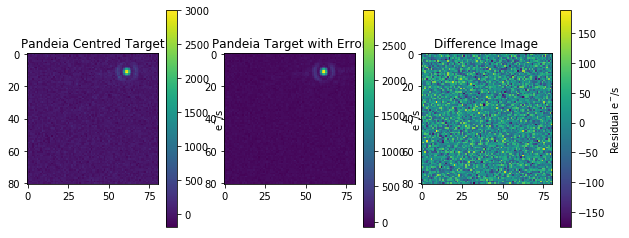

In [21]:
pandeia_slope_centred = pandeia_target_centred['2d']['detector']
pandeia_slope_errored = pandeia_target_errored['2d']['detector']
pandeia_slope_subtracted = pandeia_slope_centred - pandeia_slope_errored

plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(pandeia_slope_centred)
plt.title('Pandeia Centred Target')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(pandeia_slope_errored)
plt.title('Pandeia Target with Error')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(pandeia_slope_subtracted)
plt.title('Difference Image')
plt.colorbar().set_label('Residual e$^{-}$/s')
plt.savefig('pandeia.png')

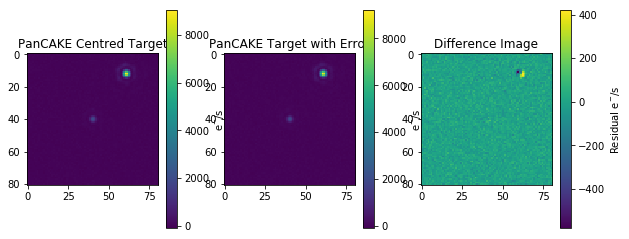

In [24]:
pancake_slope_centred = pancake_centered['target']
pancake_slope_errored = pancake_errored['target']
pancake_slope_subtracted = pancake_slope_centred - pancake_slope_errored

plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(pancake_slope_centred)
plt.title('PanCAKE Centred Target')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(pancake_slope_errored)
plt.title('PanCAKE Target with Error')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(pancake_slope_subtracted)
plt.title('Difference Image')
plt.colorbar().set_label('Residual e$^{-}$/s')
plt.savefig('pancake.png')

Once again, subtracting the panCAKE result from the pandeia result will give an idea of the differences between the two methods.

In [ ]:
difference_image = pandeia_slope - pancake_slope

plt.figure(figsize=(10,4))
plt.imshow(difference_image)
plt.title('Pandeia - PanCAKE')
plt.colorbar().set_label('e$^{-}$/s')

In this case, panCAKE has a substantially greater residual from the central star. This is as a result of its on-the-fly PSF calculation (when selecting a PSF from its library, pandeia selects the PSF closest to the supplied offset from a relatively sparse grid (for MIRI FQPM, for example, pandeia has a triangle of PSFs at 15 locations ([0,0], [0.125,0], [0.125, 0.125], [0.30, 0], [0.30, 0.125], [0.30,0.30], and so on) at a 5 degree angle to the axes, which are mirrored in 8-fold symmetry to fill the plane.) As such, pandeia is not registering the differences in PSF caused by the simulated TA error, whereas panCAKE produces a more accurate indication of the actual JWST accuracy under the circumstances.